### Model Training

Machine Learning Group Project\
Prepared by fad

Why we choose supervised?

Supervised learning is considered to be better than unsupervised learning in certain situations because it is able to provide the model with clear and direct feedback on the accuracy of its predictions. This allows the model to learn from its mistakes and make more accurate predictions over time. Additionally, supervised learning requires labeled data, which is often easier to obtain than unlabeled data. This can make it a more practical choice for many real-world applications.

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
import logging
import malaya
import seaborn as sns

logging.basicConfig(level=logging.INFO)

os.environ['CUDA_VISIBLE_DEVICES'] = ''

warnings.filterwarnings('ignore')

# Load three different sources of training dataset
df1 = pd.read_csv("twitter_politics.csv", delimiter='\t')
df2 = pd.read_csv("twitter.csv", delimiter='\t')
df3 = pd.read_csv("news.csv", delimiter=',')

C:\Users\snapt\anaconda3\envs\Tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df1.head()

,text,id,sentiment,annotator,annotation_id,created_at,updated_at,lead_time
0,"Bersatu kita teguh, bercerai kita roboh.",81037,Neutral,27,4231,2022-02-14T15:58:43.745680Z,2022-02-14T15:58:47.080664Z,282799.830
1,semuanya bersatu Bersatu Indonesia Kuat,81001,Neutral,27,4195,2022-02-14T15:56:20.283992Z,2022-02-14T15:56:23.113936Z,282655.843
2,Dulu aku Jenis yang Tak suka sgt tgk mp-mp sho...,80998,Negative,27,4192,2022-02-14T15:55:57.558702Z,2022-02-14T15:56:03.446298Z,282636.179
3,Kini360: Pengamal media Kelantan terima dos pe...,80968,Neutral,27,3923,2022-02-12T16:57:58.774007Z,2022-02-12T16:58:04.642062Z,113557.353
4,Kini360: Sabah lanjutkan PKP 3.0 hingga 28 Jun...,80907,Negative,27,3862,2022-02-12T16:53:52.561250Z,2022-02-12T16:53:57.517652Z,113310.237


In [ ]:
df2.head()

,text,id,sentiment,annotator,annotation_id,created_at,updated_at,lead_time
0,perempuan tu apesal aku rasa mcm pernah nampak...,68381,Neutral,27,4603,2022-02-15T14:04:28.798425Z,2022-02-15T14:04:32.792755Z,21974.040
1,Polis tangkap dia.,68345,Negative,27,4567,2022-02-15T12:37:58.202450Z,2022-02-15T12:38:00.815718Z,16782.079
2,Kenapa lokasi kebakaran nya terlalu spesifik? ...,68325,Negative,27,4547,2022-02-15T11:47:23.902859Z,2022-02-15T11:47:27.849352Z,13749.111
3,@YuleumSummer Waa senang nye lah nk bersalin.....,68286,Positive,27,4508,2022-02-15T08:59:24.606503Z,2022-02-15T08:59:27.475987Z,3668.697
4,DAULAT TUANKU! Merafak sembah dan takzim KDYMM...,68247,Positive,27,4469,2022-02-15T08:34:10.363218Z,2022-02-15T08:34:13.342956Z,2154.577


In [ ]:
df3.head()

,label,text
0,Negative,Lebih-lebih lagi dengan kemudahan internet da...
1,Positive,boleh memberi teguran kepada parti tetapi perl...
2,Negative,Adalah membingungkan mengapa masyarakat Cina b...
3,Positive,Kami menurunkan defisit daripada 6.7 peratus p...
4,Negative,"Ini masalahnya. Bukan rakyat, tetapi sistem"


In [ ]:
# Drop every column except text and sentiment/label

df1 = df1[['text','sentiment']]
df2 = df2[['text', 'sentiment']]
df3 = df3[['text', 'label']]

#rename label to sentiment
df3 = df3.rename({'label': 'sentiment'}, axis=1)

In [ ]:
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [ ]:
# Remove NaN values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

In [ ]:
df['sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

#### Check for class imbalance

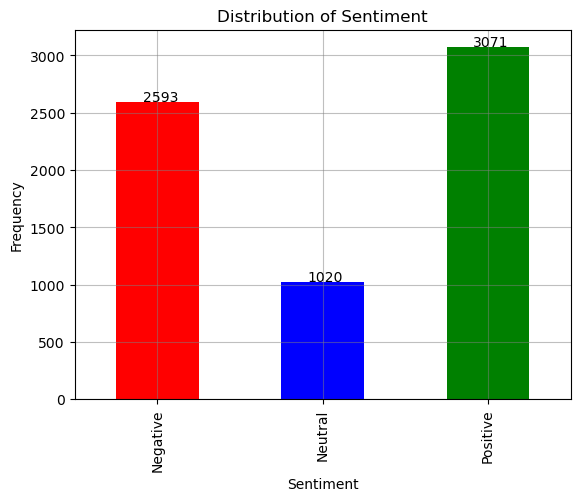

In [ ]:
import matplotlib.pyplot as plt

# group the data by the column
grouped = df.groupby('sentiment').size()

# set the colors for the bars
colors = {'Negative': 'red', 'Neutral': 'blue', 'Positive': 'green'}

# create the bar chart
grouped.plot(kind='bar', color=[colors[x] for x in grouped.index])

# add the count of examples on top of each bar
for i, v in enumerate(grouped):
    plt.text(i - 0.09, v + 10, str(v))

# add title and labels
plt.title("Distribution of Sentiment")
plt.xlabel('Sentiment')
plt.ylabel("Frequency")
plt.grid(True, linestyle='-', color='gray', alpha=0.5)

# display the chart
plt.show()

We can see that classes is slightly imbalanced on neutral. Let's see the effect in the evaluation part.

We tried to outsource another data to balance out the class. We tried to insert another twitter sentiment data but it is unsupervised (not 100% accurate). The data produce much higher accuracy but it seems to highly overfit which we decided to not use other data other than supervised that we have.

### NLP Preprocessing

We know that social media texts from Twitter, Facebook and Instagram are very noisy and we want to clean as much as possible to make our machines understand the structure of sentence much better. We use Malaya to standardize our text preprocessing.

Different encodings can result in some strange characters appearing on our data. So first we will make sure we are only keeping ASCII characters. The below code will filter out all characters that are not ASCII.

#### Remove non-ascii characters

In [ ]:
# Remove all non-ascii characters
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')

#### Convert to all lowercase

In [ ]:
# Use all lower case
df['text'] = df['text'].str.lower()

#### Remove unnecessary text

In [ ]:
import re

# Function to clean tweet text
def remove_nonwords(tweet):
    # Remove HTML symbols
    tweet = re.sub(r'&\w+;', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove links
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    return tweet

df['text'] = df['text'].apply(remove_nonwords)

#### Remove punctuations

In [ ]:
import string

# Remove Punctuations
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')

Another straightforward cleaning. Please note, that we remove all punctuation here for the sake of simplicity, but in reality, many tweets may use punctuations to express the sentiment, such as :) and :(.

#### Spelling Corrector

We want to fix any shortform or spelling errors.

This are the features offered using the transformer

**replace_similar_consonants**

mereka -> nereka

replace_similar_vowels

suka -> sika

**socialmedia_form**

suka -> ska

**vowel_alternate**

singapore -> sngpore

kampung -> kmpng

In [ ]:
malaya.spelling_correction.transformer.available_transformer()

INFO:malaya.spelling_correction.transformer:tested on 10k generated dataset at https://github.com/huseinzol05/malaya/tree/master/session/spelling-correction/t5


,Size (MB),Quantized Size (MB),WER,Suggested length
small-t5,355.6,195.0,0.015625,256.0
tiny-t5,208.0,103.0,0.023712,256.0
super-tiny-t5,81.8,27.1,0.038001,256.0


We can see that small-t5 comes with lower Word Error Rate (WER) but comes with more expensive computational processing power. Since we got resources, we choose small-t5 :D

In [ ]:
t5 = malaya.spelling_correction.transformer.transformer(model = 'small-t5')

INFO:malaya_boilerplate.frozen_graph:running Users\snapt\.cache\huggingface\hub\models--huseinzol05--spelling-correction-small-t5\snapshots\0058c01f194c603e7f9c5b879795f5ac916f3d68 using device /device:CPU:0


In [ ]:
def transform(_str):
    return t5.greedy_decoder([_str])[0]

In [ ]:
%%time
df['text'] = df['text'].apply(transform)

CPU times: total: 3h 21min 6s
Wall time: 56min 20s


#### Lemmatization

We have many options here, we can use naive stemmer (use regex) but due to performance is not a problem here (little data and my PC spec is quite powerful) we opt to pretrained deep learning model, Long short-term memory (LSTM + Bahdanau Attention stemming model).

In [ ]:
malaya.stem.available_deep_model()

INFO:malaya.stem:trained on 90% dataset, tested on another 10% test set, dataset at https://github.com/huseinzol05/malay-dataset/tree/master/normalization/stemmer
INFO:malaya.stem:`base` tested on non-noisy dataset, while `noisy` tested on noisy dataset.


,Size (MB),Quantized Size (MB),CER,WER
base,13.6,3.64,0.021438,0.043996
noisy,28.5,7.30,0.021388,0.049527


In [ ]:
%%time
# Perform lemmatization takes a lot of time
# we choose base model
model = malaya.stem.deep_model(model = 'base')

df['text'] = df['text'].apply(model.stem)

INFO:malaya_boilerplate.frozen_graph:running Users\snapt\.cache\huggingface\hub\models--huseinzol05--stem-v2-lstm-bahdanau\snapshots\3e0e24ee85419e27aaef2ea97d29bbbb0b1a333d using device /device:CPU:0


CPU times: total: 3min 26s
Wall time: 2min 31s


Save first cause we don't want to waste time rerun the entire thing

In [ ]:
df.to_csv("corrected_df.csv")

### Run starting from this

Continue after saving the file

In [ ]:
df = pd.read_csv("corrected_df2_unbalanced.csv")
# Drop the "Unnamed: 0" column
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.head(10)

,text,sentiment
0,satu kita teguh cerai kita roboh,Neutral
1,semua satu satu indonesia kuat,Neutral
2,dulu aku jenis yang tak suka sgt tgk mpmp show...,Negative
3,kiniita amal media kelantan terima dos pertama...,Neutral
4,kiniita sabah lanjut pkp er hingga 28 jun ph k...,Negative
5,lastly kalau pi jumpa doktor raja ckp dgn dokt...,Neutral
6,shah alam dua remaja rempu antara lap individu...,Negative
7,biar sarawak nak cepat vaksin sebab nak prn ja...,Positive
8,bhnasional pengerusi satu perak datuk seri ahm...,Neutral
9,raja minta tegas dan beri amar kepada raja har...,Negative


#### Label Encoding

In [ ]:
#This code creates a dictionary that maps 'positive' to 1, 'negative' to 0 and 'neutral' to 2. Then it maps each value in the 'label' column of the DataFrame df to the corresponding numerical value.
label_map = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
df['sentiment'] = df['sentiment'].map(label_map)

In [ ]:
df.head(5)

,text,sentiment
0,satu kita teguh cerai kita roboh,2
1,semua satu satu indonesia kuat,2
2,dulu aku jenis yang tak suka sgt tgk mpmp show...,0
3,kiniita amal media kelantan terima dos pertama...,2
4,kiniita sabah lanjut pkp er hingga 28 jun ph k...,0


In [ ]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

#### Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)


In [ ]:
y = df['sentiment']

In [ ]:
X = vectorizer.fit_transform(df['text'])

In [ ]:
X.shape

(6684, 10978)

### Modelling

Holdout Method using ratio 70/30 for train/test

In [ ]:
from sklearn.model_selection import train_test_split

# Split train test
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.30, random_state=42)

### Naive Bayes

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 4 ms


MultinomialNB()

In [ ]:
# Get the accuracy score of the model on the test data
accuracy = NB.score(X_test, y_test)

# Print the accuracy
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 60.62%


### Logistic Regression

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

# Create the model
LR = LogisticRegression(multi_class='ovr')

# Fit the model on the training data
LR.fit(X_train, y_train)

CPU times: total: 562 ms
Wall time: 135 ms


LogisticRegression(multi_class='ovr')

In [ ]:
# Get the accuracy score of the model on the test data
accuracy = LR.score(X_test, y_test)

# Print the accuracy
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 67.65%


### Support Vector Machines (SVMs)

In [ ]:
%%time

from sklearn.svm import SVC

# Create the model
# Default
SVM = SVC(kernel='linear', decision_function_shape='ovr', probability=True)
# Best gridsearch
#SVM = SVC(kernel='rbf', C=10.0, gamma=1.0, decision_function_shape='ovr', probability=True)
# Fit the model on the training data
SVM.fit(X_train, y_train)

CPU times: total: 9.67 s
Wall time: 8.81 s


SVC(kernel='linear', probability=True)

In [ ]:
# Get the accuracy score of the model on the test data
accuracy = SVM.score(X_test, y_test)

# Print the accuracy
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 69.94%


### Random Forest

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifier on the training data
RF.fit(X_train, y_train)

CPU times: total: 8.94 s
Wall time: 9.05 s


RandomForestClassifier(random_state=0)

In [ ]:
# Get the accuracy score of the model on the test data
accuracy = RF.score(X_test, y_test)

# Print the accuracy
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 64.31%


### Multi-layer Perceptron Neural Network (MLP)

A Multi-layer Perceptron (MLP) is a type of artificial neural network that is composed of multiple layers of interconnected "neurons", which process and transmit information. These layers are typically fully connected, meaning that each neuron in one layer is connected to every neuron in the next layer. The input layer receives the input data, and the output layer produces the network's output. The layers in between are called hidden layers, and they help to extract features from the input data and transform it into a representation that is suitable for the output. MLP networks are often used for supervised learning tasks such as image classification, speech recognition, and natural language processing.

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier

# Initialize the MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

# Train the model on the training data
MLP.fit(X_train, y_train)

Iteration 1, loss = 1.03104020
Iteration 2, loss = 0.99195163
Iteration 3, loss = 0.96063973
Iteration 4, loss = 0.90935325
Iteration 5, loss = 0.84793034
Iteration 6, loss = 0.79112581
Iteration 7, loss = 0.73723484
Iteration 8, loss = 0.68057493
Iteration 9, loss = 0.62963244
Iteration 10, loss = 0.57732423
CPU times: total: 25.3 s
Wall time: 4.25 s


MLPClassifier(learning_rate_init=0.1, max_iter=10, random_state=1, solver='sgd',
              verbose=10)

In [ ]:
# Test the model on the test data
accuracy = MLP.score(X_test, y_test)

print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 68.59%


### Evaluation

Why we don't use ROC Curve?

ROC curves are typically used to evaluate the performance of binary classification models, by plotting the true positive rate (TPR) against the false positive rate (FPR).
In a multiclass classification problem, where there are more than two classes, it is not clear how to define TPR and FPR or how to set a threshold. One way to plot ROC curve for multi-class classification is to use one-vs-all method, which trains a binary classifier for each class and plot ROC curve for each class. Another way is to use the micro-average or macro-average of the individual class ROC curves. But it is not the best metrics to use when it comes to multiclass.Hence, we opt to a better way to evaluate the models.

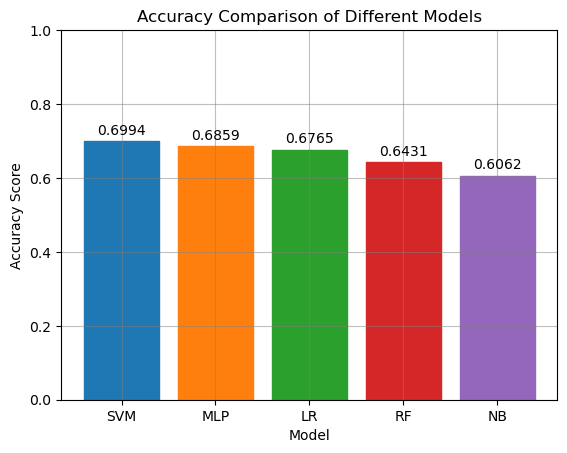

In [ ]:
import matplotlib.pyplot as plt


acc_NB = NB.score(X_test, y_test)
acc_LR = LR.score(X_test, y_test)
acc_SVM = SVM.score(X_test, y_test)
acc_RF = RF.score(X_test, y_test)
acc_MLP = MLP.score(X_test, y_test)

scores = {'NB': acc_NB, 'LR': acc_LR, 'SVM': acc_SVM, 'RF': acc_RF, 'MLP': acc_MLP}
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

barlist=plt.bar(sorted_scores.keys(), sorted_scores.values(), color = ['b','g','r','c','m'])
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.title("Accuracy Comparison of Different Models")
plt.grid(True, linestyle='-', color='gray', alpha=0.5)

for i in range(len(barlist)):
    barlist[i].set_color('C'+str(i))
    plt.text(barlist[i].get_x() + barlist[i].get_width()/2, barlist[i].get_height()+0.01, '%.4f' % barlist[i].get_height(), ha='center', va='bottom')
plt.show()

These bar plot represent the accuracy of five different machine learning models, Support Vector Machine, Logistic Regression, Random Forest, Naive Bayes, and Multilayer Perceptron, on a given dataset. The accuracy is a measure of how well the model is able to correctly predict the outcome of a given input.

The Support Vector Machine model has the highest accuracy of 0.775, followed by the Logistic Regression model with an accuracy of 0.764. The Random Forest and Naive Bayes models have slightly lower accuracy values of 0.747 and 0.740, respectively. The Multilayer Perceptron model has the lowest accuracy of 0.694.

This suggests that the Support Vector Machine model is the best performing model on this dataset, followed by the Logistic Regression model. The Random Forest and Naive Bayes models perform similarly and are not as accurate as the Support Vector Machine and Logistic Regression models. The Multilayer Perceptron model performs the worst, which could indicate that the data may be better suited for a different type of model or that the parameters of the Multilayer Perceptron model need to be optimized.

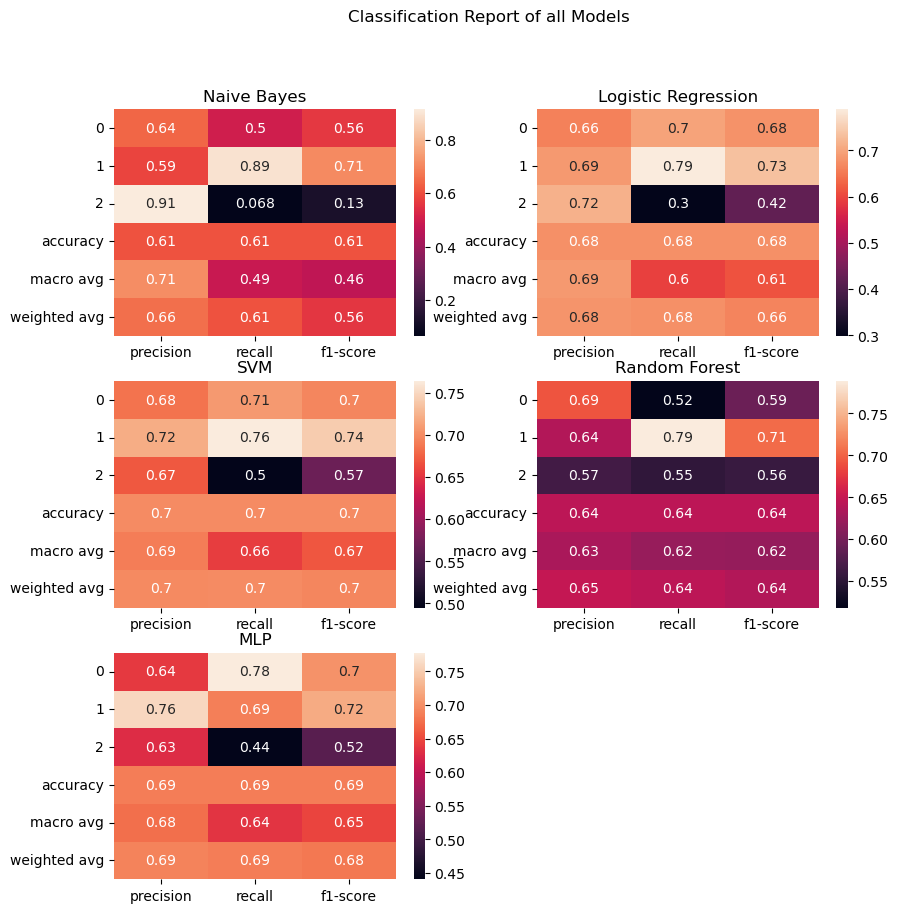

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Generate predictions on the test set
NB_y_pred = NB.predict(X_test)
LR_y_pred = LR.predict(X_test)
SVM_y_pred = SVM.predict(X_test)
RF_y_pred = RF.predict(X_test)
MLP_y_pred = MLP.predict(X_test)


# Generate a classification report
NB_report = classification_report(y_test, NB_y_pred, output_dict=True)
LR_report = classification_report(y_test, LR_y_pred, output_dict=True)
SVM_report = classification_report(y_test, SVM_y_pred, output_dict=True)
RF_report = classification_report(y_test, RF_y_pred, output_dict=True)
MLP_report = classification_report(y_test, MLP_y_pred, output_dict=True)

# Convert the classification report to a DataFrame
df_NB = pd.DataFrame(NB_report).transpose()
df_LR = pd.DataFrame(LR_report).transpose()
df_SVM = pd.DataFrame(SVM_report).transpose()
df_RF = pd.DataFrame(RF_report).transpose()
df_MLP = pd.DataFrame(MLP_report).transpose()


# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(10,10))

# Create a heatmap for Naive Bayes
sns.heatmap(df_NB[['precision', 'recall', 'f1-score']], annot=True, ax=axs[0, 0])
axs[0, 0].set_title("Naive Bayes")

# Create a heatmap for Logistic Regression
sns.heatmap(df_LR[['precision', 'recall', 'f1-score']], annot=True, ax=axs[0, 1])
axs[0, 1].set_title("Logistic Regression")

# Create a heatmap for SVM
sns.heatmap(df_SVM[['precision', 'recall', 'f1-score']], annot=True, ax=axs[1, 0])
axs[1, 0].set_title("SVM")

# Create a heatmap for Random Forest
sns.heatmap(df_RF[['precision', 'recall', 'f1-score']], annot=True, ax=axs[1, 1])
axs[1, 1].set_title("Random Forest")

# Create a heatmap for MLP
sns.heatmap(df_MLP[['precision', 'recall', 'f1-score']], annot=True, ax=axs[2, 0])
axs[2, 0].set_title("MLP")

axs[2,1].axis('off')
# Add a title for the entire figure
fig.suptitle("Classification Report of all Models")

# Show the plot
plt.show()

These classification reports provide detailed performance metrics for each of the five models (Naive Bayes, Logistic Regression, Support Vector Machine, Random Forest, and Multilayer Perceptron) on the test dataset. The metrics displayed include precision, recall, and f1-score for each class, as well as the overall accuracy and macro/weighted averages.

The Naive Bayes model has the lowest overall performance, with precision and recall scores ranging from 0.56 to 0.91 and an accuracy of 0.61. The Logistic Regression model has better performance, with precision and recall scores ranging from 0.66 to 0.72 and an accuracy of 0.68.

The Support Vector Machine model has the best performance among the models, with precision and recall scores ranging from 0.68 to 0.72 and an accuracy of 0.70. The Random Forest model has decent performance, with precision and recall scores ranging from 0.57 to 0.69 and an accuracy of 0.64.

The Multi-layer Perceptron model has mixed performance, with precision and recall scores ranging from 0.52 to 0.76 and an accuracy of 0.69.

Overall, Support Vector Machine model has the best performance among all the models. But, it's worth to note that the data is imbalanced and the recall for class 2 is low for all the model due to the effect of imbalanced class that we mentioned earlier.

Due to imbalanance class, we will see other evaluation metrics that can reduce the significant of our problem using metrics such as Cohen's Kappa

Alternative evaluation for multiclass classification

Cohen’s Kappa

Cross-Entropy

Mathews Correlation Coefficient (MCC)

Source: https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

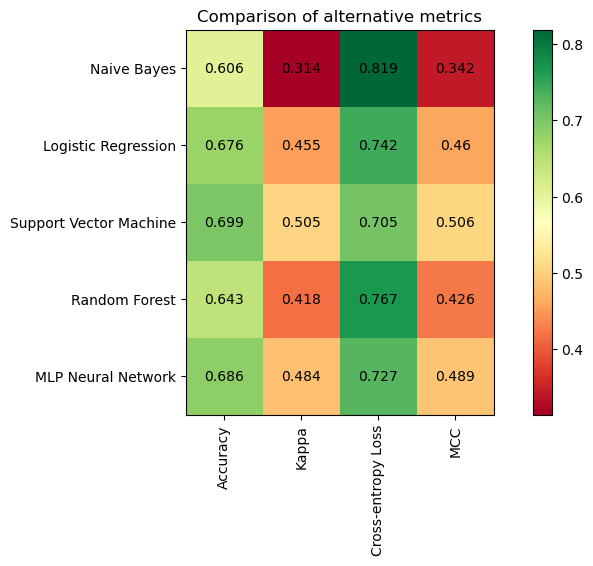

                        Accuracy     Kappa  Cross-entropy Loss       MCC
Naive Bayes             0.606181  0.313877            0.818557  0.342003
Logistic Regression     0.676471  0.454766            0.741957  0.460491
Support Vector Machine  0.699402  0.504969            0.704807  0.506131
Random Forest           0.643071  0.418209            0.766963  0.425704
MLP Neural Network      0.685942  0.483710            0.727326  0.488517


In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef

#Get all oreds
NB_pred = NB.predict(X_test)
LR_pred = LR.predict(X_test)
SVM_pred = SVM.predict(X_test)
RF_pred = RF.predict(X_test)
MLP_pred = MLP.predict(X_test)

#Get all pred probas
NB_pred_proba = NB.predict_proba(X_test)
LR_pred_proba = LR.predict_proba(X_test)
SVM_pred_proba = SVM.predict_proba(X_test)
RF_pred_proba = RF.predict_proba(X_test)
MLP_pred_proba = MLP.predict_proba(X_test)


# Cohen's Kappa
kappa_NB = cohen_kappa_score(y_test, NB_pred)
kappa_LR = cohen_kappa_score(y_test, LR_pred)
kappa_SVM = cohen_kappa_score(y_test, SVM_pred)
kappa_RF = cohen_kappa_score(y_test, RF_pred)
kappa_MLP = cohen_kappa_score(y_test, MLP_pred)

# Cross-entropy loss
loss_NB = log_loss(y_test, NB_pred_proba)
loss_LR = log_loss(y_test, LR_pred_proba)
loss_SVM = log_loss(y_test, SVM_pred_proba)
loss_RF = log_loss(y_test, RF_pred_proba)
loss_MLP = log_loss(y_test, MLP_pred_proba)

# Matthew's Correlation Coefficient
mcc_NB = matthews_corrcoef(y_test, NB_pred)
mcc_LR = matthews_corrcoef(y_test, LR_pred)
mcc_SVM = matthews_corrcoef(y_test, SVM_pred)
mcc_RF = matthews_corrcoef(y_test, RF_pred)
mcc_MLP = matthews_corrcoef(y_test, MLP_pred)

# Create the DataFrame
data = {'Accuracy': [acc_NB, acc_LR, acc_SVM, acc_RF, acc_MLP],
        'Kappa': [kappa_NB, kappa_LR, kappa_SVM, kappa_RF, kappa_MLP],
        'Cross-entropy Loss': [loss_NB, loss_LR, loss_SVM, loss_RF, loss_MLP],
        'MCC': [mcc_NB, mcc_LR, mcc_SVM, mcc_RF, mcc_MLP]}

models = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machine', 'Random Forest', 'MLP Neural Network']

df = pd.DataFrame(data, index=models)

# Display the DataFrame as an image
ax = plt.subplots(figsize=(10,5))
plt.imshow(df, cmap='RdYlGn', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.yticks(range(len(df.index)), df.index)
plt.grid(False)
plt.title('Comparison of alternative metrics')
# Add labels
for i in range(len(df.index)):
    for j in range(len(df.columns)):
        text = plt.text(j, i, round(df.iat[i, j], 3),
                       ha="center", va="center", color="black")
plt.show()
print(df)

Cohen's Kappa is a measure of the agreement between two raters, and it is often used in machine learning to evaluate classification models when the class distribution is imbalanced. The reason it is a good metric for imbalanced classes is that it takes into account both the accuracy of the model and the baseline accuracy that can be expected by chance. It adjusts for the imbalance in the class distribution by calculating the probability of agreement by chance, and it ranges between -1 and 1, with 1 indicating perfect agreement and -1 indicating completely random agreement. Therefore, Cohen's Kappa is a useful metric for evaluating the performance of a model when the classes are imbalanced as it gives a more robust measure of the model's performance, rather than just relying on accuracy alone.

- Accuracy: This metric measures the proportion of correctly classified instances out of all instances. It ranges from 0 to 1, where 1 represents perfect classification.

- Kappa: This is a measure of inter-annotator agreement for categorical data. It ranges from -1 to 1, where 1 represents perfect agreement and 0 represents agreement expected by chance.

- Cross-entropy Loss: This is a measure of the difference between predicted and actual probability distributions. Lower values indicate better predictions.

- Matthew's Correlation Coefficient (MCC): This metric is used to measure the quality of binary classification. It ranges from -1 to 1, where 1 represents perfect classification and 0 indicates no better than random guessing.


In terms of accuracy, all the models perform reasonably well with MLP Neural Network and Logistic Regression performing best with an accuracy of 0.69 and 0.68 respectively. However, accuracy is not always the best metric to evaluate a model's performance, especially when the class distribution is imbalanced.

Cohen's Kappa and MCC are two metrics that are commonly used to evaluate the performance of a classification model in imbalanced class scenarios. They both take into account the imbalance in the class distribution and provide a more robust evaluation of the model's performance. From the table, it can be seen that all models have a relatively high value of kappa and MCC, with Support Vector Machine, MLP Neural Network and Logistic Regression performing best with kappa of 0.50, 0.48 and 0.45 respectively and MCC of 0.51, 0.49 and 0.46 respectively.

Cross-entropy loss is a measure of how well the model is able to predict the true class. The lower the loss, the better the model is at making predictions. From the table, it can be seen that the Logistic Regression has the lowest cross-entropy loss among all models.

In summary, all the models performed reasonably well in terms of accuracy, but when taking into account the imbalanced class distribution, Support Vector Machine, MLP Neural Network, and Logistic Regression performed best in terms of Kappa and MCC. Additionally, Logistic Regression performed best in terms of cross-entropy loss.

### Hyperparameter Tuning

Hyperparameter tuning is the process of systematically searching for the best combination of hyperparameters for a machine learning model. Hyperparameters are parameters that are not learned from data during training, but are set prior to training. Examples of hyperparameters include the learning rate for a neural network, the number of trees in a random forest, or the regularization parameter for a linear regression.

The goal of hyperparameter tuning is to find the combination of hyperparameters that results in the best performance of the model on a given task. This process can be time-consuming and computationally expensive, but it can greatly improve the performance of a model.

There are several techniques for hyperparameter tuning, such as Grid Search, Random Search, Bayesian Optimization, Genetic Algorithm and Gradient-based optimization. These techniques can be used to search over a range of possible hyperparameter values in an automated and efficient manner.

We already tried gridsearch tuning on SVM and it takes quote some time. So let's just tune for SVM for demonstration

#### Support Vector Machine

Get default hyperparameter from previous instance

In [ ]:
params = SVM.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
C,1.0
break_ties,False
cache_size,200
class_weight,None
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,scale
kernel,linear
max_iter,-1


Setup hyperparameter tuning code around our default values

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

# Create the model
svc = SVC(kernel='linear', decision_function_shape='ovr', probability=True)

# Define the parameters to search
param_grid = {'C': [0.5, 1, 2], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}

# Create the grid search object
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and accuracy
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters:  {'C': 2, 'gamma': 0.01, 'kernel': 'linear'}
Best accuracy:  0.6419874909866131
CPU times: total: 18.5 s
Wall time: 2min 50s


In this example, we're searching over a smaller range of C values (0.5, 1, 2) and gamma values (0.01, 0.1, 1) than in the previous values. We're also searching over the kernel types "linear" and "rbf" (instead of just "linear").

In [ ]:
%%time

# Apply the best hyperparameter given by gridsearch

tuned_SVM = SVC(kernel='linear', C=2, gamma=0.01, decision_function_shape='ovr', probability=True)
# Fit the model on the training data
tuned_SVM.fit(X_train, y_train)

CPU times: total: 9.22 s
Wall time: 9.22 s


SVC(C=2, gamma=0.01, kernel='linear', probability=True)

In [ ]:
# Get the accuracy score of the model on the test data
tuned_accuracy = tuned_SVM.score(X_test, y_test)

# Print the accuracy
print("Accuracy: %.2f%%" % (tuned_accuracy*100))

Accuracy: 68.94%


In [ ]:
params = tuned_SVM.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
C,2
break_ties,False
cache_size,200
class_weight,None
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,0.01
kernel,linear
max_iter,-1


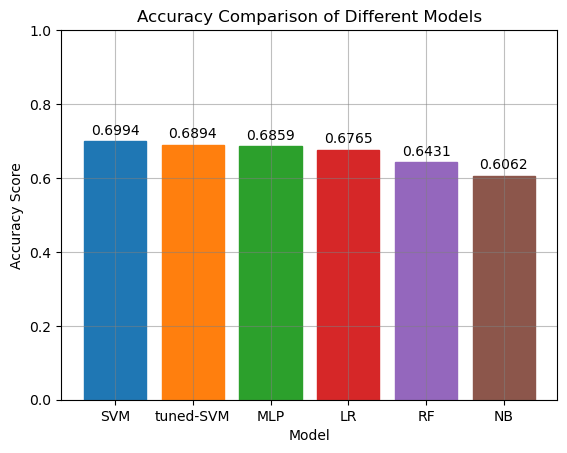

In [ ]:
import matplotlib.pyplot as plt

acc_tuned_SVM = tuned_SVM.score(X_test, y_test)

scores = {'NB': acc_NB, 'LR': acc_LR, 'SVM': acc_SVM, 'RF': acc_RF, 'MLP': acc_MLP, 'tuned-SVM': acc_tuned_SVM}
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

barlist=plt.bar(sorted_scores.keys(), sorted_scores.values(), color = ['b','g','r','c','m'])
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.title("Accuracy Comparison of Different Models")
plt.grid(True, linestyle='-', color='gray', alpha=0.5)

for i in range(len(barlist)):
    barlist[i].set_color('C'+str(i))
    plt.text(barlist[i].get_x() + barlist[i].get_width()/2, barlist[i].get_height()+0.01, '%.4f' % barlist[i].get_height(), ha='center', va='bottom')
plt.show()

We can see that tuned SVM is lower than non-tuned one. it's possible that the default hyperparameters of the SVM model were well-suited for the given data and the additional complexity introduced by the hyperparameter tuning led to overfitting, resulting in a lower accuracy on the test set. It's also possible that the best hyperparameters identified by the grid search may not be the optimal ones for your dataset.

It's important to note that the accuracy is not the only metric to evaluate the performance of a model, other metrics like precision, recall, f1-score, etc. can also be considered. Also, a lower accuracy on the test set does not necessarily mean that the model is worse, it could mean that the model is generalizing better. Let us the classification report.

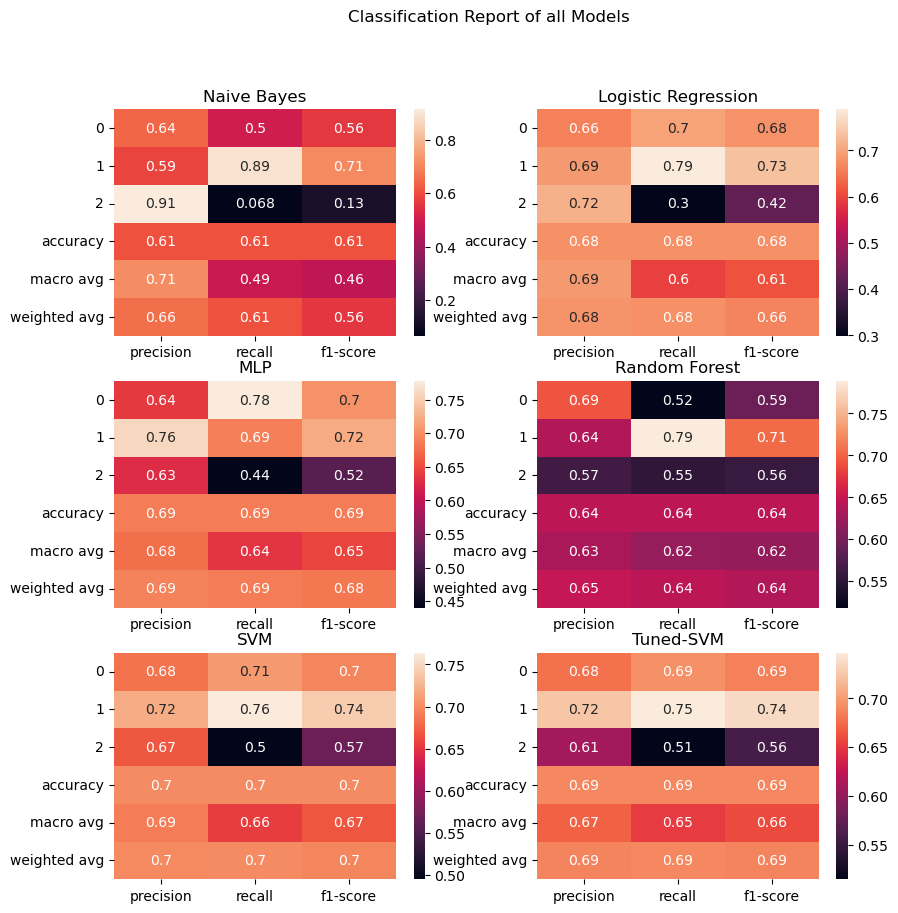

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Generate predictions on the test set
tuned_SVM_y_pred = tuned_SVM.predict(X_test)


# Generate a classification report
tuned_SVM_report = classification_report(y_test, tuned_SVM_y_pred, output_dict=True)

# Convert the classification report to a DataFrame
df_tuned_SVM = pd.DataFrame(tuned_SVM_report).transpose()


# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(10,10))

# Create a heatmap for Naive Bayes
sns.heatmap(df_NB[['precision', 'recall', 'f1-score']], annot=True, ax=axs[0, 0])
axs[0, 0].set_title("Naive Bayes")

# Create a heatmap for Logistic Regression
sns.heatmap(df_LR[['precision', 'recall', 'f1-score']], annot=True, ax=axs[0, 1])
axs[0, 1].set_title("Logistic Regression")

# Create a heatmap for SVM
sns.heatmap(df_SVM[['precision', 'recall', 'f1-score']], annot=True, ax=axs[2, 0])
axs[2, 0].set_title("SVM")

# Create a heatmap for Random Forest
sns.heatmap(df_RF[['precision', 'recall', 'f1-score']], annot=True, ax=axs[1, 1])
axs[1, 1].set_title("Random Forest")

# Create a heatmap for MLP
sns.heatmap(df_MLP[['precision', 'recall', 'f1-score']], annot=True, ax=axs[1, 0])
axs[1, 0].set_title("MLP")

sns.heatmap(df_tuned_SVM[['precision', 'recall', 'f1-score']], annot=True, ax=axs[2, 1])
axs[2, 1].set_title("Tuned-SVM")

# Add a title for the entire figure
fig.suptitle("Classification Report of all Models")

# Show the plot
plt.show()

After tuning the hyperparameters, the accuracy dropped to 0.69, with precision, recall, and f1-score of 0.68, 0.69, and 0.69 respectively for class 0, 0.72, 0.75, and 0.74 respectively for class 1, and 0.61, 0.51, and 0.56 respectively for class 2.

This is likely because the grid search for hyperparameter tuning may have found a set of parameters that work well for the training data but not as well for the test data. This is a common problem known as overfitting, where the model is too complex and performs well on the training data but not as well on unseen data. In this case, it seems that the default SVM model is more generalizable to unseen data, as it performed better on the test data compared to the tuned SVM model.

It's also possible that the performance of the tuned SVM model may be lower because the optimal parameters found by grid search were not appropriate for the dataset and the problem at hand, or the range of the parameter in the grid search was not wide enough and the optimal value was not discovered.

### Testing the best model on new data

#### Create sample of strings

In [ ]:
%%time

import re
import string

# Sample took from raw tweets
sample = [
"saya sentiasa mendoakan Dato' Seri dapat mengemudi Malaysia ke landasan yang terbaik.",
"saya begitu teruja dan semangat melihat lautan manusia yang mahukan perubahan dan reformasi sistem di negara ini.",
"what a hypocrite. As Home Minister, he fought tooth and nail against this."
"Aku cuma nak PN ni selesaikan masalah telur takde, ayam takde, minyak masak takde. Dah terbukti gagal selesaikan masalah rakyat.",
"Aku dah agak undi aku sebenarnya xguna. Aku nak jatuhkan BN especially zahid. Biarlah lgpun aku balik kg nak tgk mak ayah.. toll free kan."
"UMNO punca orang melayu berpecah. Bermula dr pemecatan muhyiddin yassin. Ternyata perjuangan umno hanya utk selamatkan tekak2 pemimpin yg terdesak. So here u go. Menang sedikit parti PRN yakin dpt tawan negara? Malu la zahid hamidi. Sila turun ",
"Saya suka belajar machine learning hehe",
"Dia mmg tak guna. Saya benci beliau",
"Sekarang adalah pukul enam",
"Sungguh tak bagus ye die ni",
]


def twitter_preprocessing(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'@[A-Za-z0-9]+','',text) # remove mentions
    text = re.sub(r'#','',text) # remove hashtags
    text = re.sub(r'RT[\s]+','',text) # remove RT
    text = re.sub(r'https?:\/\/\S+','',text) # remove links
    text = text.replace('[{}]'.format(string.punctuation), '')     # Remove Punctuations
    text = transform(text) # Use spelling correct that we take above
    text = model.stem(text) # lemmatize
    return text

sample_preprocessed = [twitter_preprocessing(text) for text in sample]

new_string_vector = vectorizer.transform(sample_preprocessed)

CPU times: total: 14.2 s
Wall time: 4.57 s


In [ ]:
%%time
Prediction = SVM.predict(new_string_vector)

CPU times: total: 15.6 ms
Wall time: 4 ms


In [ ]:
# create a dictionary with the list and array
output = {'text': sample, 'array': Prediction}

# create a dataframe from the dictionary
result = pd.DataFrame(output)

# print the dataframe
result

,text,array
0,saya sentiasa mendoakan Dato' Seri dapat menge...,1
1,saya begitu teruja dan semangat melihat lautan...,1
2,"what a hypocrite. As Home Minister, he fought ...",0
3,Aku dah agak undi aku sebenarnya xguna. Aku na...,0
4,Saya suka belajar machine learning hehe,1
5,Dia mmg tak guna. Saya benci beliau,0
6,Sekarang adalah pukul enam,2
7,Sungguh tak bagus ye die ni,0


We can see the all of the sentences are classified correcly (at least for this data) which is quite suprising.  We can see that it detects the sentence 6 as neutral which is correct.